<a href="https://colab.research.google.com/github/TesNikk/ML-DL/blob/main/Covid_Normal_PneumoniaClassification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing library

In [1]:
from google.colab import files
import zipfile
import os
import shutil #lets us copy files(shell utilities)
import uuid
from pathlib import Path
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten,
                                     BatchNormalization, Conv2D, MaxPooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


#Mount the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# uploaded = files.upload()

root_dir = "/content/dataset/dataset"

if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

with zipfile.ZipFile("/content/drive/MyDrive/Datasets/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

# Now your dataset is at: /content/dataset/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Prepare paths and labels

In [4]:

# OR if using Google Drive:
# root_dir = '/content/drive/MyDrive/Datasets/dataset'

image_paths =[]
labels = []

class_to_label = {"covid": 0, "normal": 1, "pneumonia": 2}

for class_name in class_to_label:
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        for subdir, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith((".jpg", ".png", ".tif")):  # handle all formats
                    image_paths.append(os.path.join(subdir, file))
                    labels.append(class_to_label[class_name])

print(f"Total images: {len(image_paths)}")


Total images: 9584


#Straitified split
ensures that the proportion of each class in the original dataset is preserved in both the training and testing sets

In [5]:
train_paths,test_paths,train_labels,test_labels = train_test_split(
    image_paths,labels,
    test_size=0.2,
    stratify= labels, #while splitting maintain the proportion of original dataset
    random_state=42
)

print(f"✅ Train split: {len(train_paths)} | Test split: {len(test_paths)}")


✅ Train split: 7667 | Test split: 1917


#Copy to new folder

In [6]:
# Optional safety: Clear existing dataset_split directory
split_base = "/content/dataset_split"
if os.path.exists(split_base):
    shutil.rmtree(split_base)
print("🧹 Cleared existing dataset_split folder.")

# Step 3: Copy to dataset_split folders
for split, paths, split_labels in [("train", train_paths, train_labels), ("test", test_paths, test_labels)]:
    for img_path, label in zip(paths, split_labels):
        class_name = [k for k, v in class_to_label.items() if v == label][0]
        out_dir = Path(f"/content/dataset_split/{split}/{class_name}")
        out_dir.mkdir(parents=True, exist_ok=True)

        unique_name = f"{uuid.uuid4().hex}_{os.path.basename(img_path)}"
        shutil.copy(img_path, out_dir / unique_name)

# Step 4: Verify
train_count = sum(len(files) for _, _, files in os.walk("/content/dataset_split/train"))
test_count = sum(len(files) for _, _, files in os.walk("/content/dataset_split/test"))
print(f"✅ Files actually copied:")
print(f"   - Train folder: {train_count}")
print(f"   - Test folder: {test_count}")


🧹 Cleared existing dataset_split folder.
✅ Files actually copied:
   - Train folder: 7667
   - Test folder: 1917


#Load the dataset

In [ ]:
# transform = transforms.Compose(
#     [
#         transforms.Grayscale(num_output_channels=1),
#         transforms.Resize((224,224)),
#         transforms.ToTensor(), #converting it into matrix and divides by 255
#     ]
# )

# # train_dataset = datasets.ImageFolder("/content/drive/MyDrive/Datasets/dataset_split/train", transform=transform)
# # test_dataset = datasets.ImageFolder("/content/drive/MyDrive/Datasets/dataset_split/test", transform=transform)

# train_dataset = datasets.ImageFolder("/content/dataset_split/train", transform=transform)
# test_dataset = datasets.ImageFolder("/content/dataset_split/test", transform=transform)


# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# print("Train classes:", train_dataset.classes)
# print("Train size:", len(train_dataset))
# print("Test size:", len(test_dataset))

#Check Class Balance

In [ ]:
# from collections import Counter

# train_labels = [label for _, label in train_dataset] #_ means i dont care bout the 1st item in each tuple
# test_labels = [label for _, label in test_dataset]

# print("Train class counts:", Counter(train_labels))
# print("Test class counts:", Counter(test_labels))


#Data Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,       # Reduce rotation
    width_shift_range=0.05, # Reduce shift
    height_shift_range=0.05,
    zoom_range=0.05,        # Reduce zoom
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Just normalize test images


#Data loading using flow_from_directory without augmentation

In [37]:
batch = 16
train_generator = train_datagen.flow_from_directory(
    #'/content/drive/MyDrive/Datasets/dataset_split/train',
    '/content/dataset_split/train',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=batch,
    class_mode='sparse',   # Use 'categorical' if one-hot labels
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    #'/content/drive/MyDrive/Datasets/dataset_split/test',
   '/content/dataset_split/test',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=batch,
    class_mode='sparse',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)
print("Train size:", train_generator.samples)
print("Test size:", test_generator.samples)
print("Train generator classes:", train_generator.class_indices)
print("Test generator classes:", test_generator.class_indices)



Found 7667 images belonging to 3 classes.
Found 1917 images belonging to 3 classes.
Class indices: {'covid': 0, 'normal': 1, 'pneumonia': 2}
Train size: 7667
Test size: 1917
Train generator classes: {'covid': 0, 'normal': 1, 'pneumonia': 2}
Test generator classes: {'covid': 0, 'normal': 1, 'pneumonia': 2}


#Class weights

In [38]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(0.5378086419753086), 1: np.float64(1.1189433741973147), 2: np.float64(4.050184891706286)}


#Building the Model

In [39]:
model = Sequential([
    Conv2D(64, (3, 3), input_shape=(224, 224, 1), activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    BatchNormalization(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),

    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # or categorical_crossentropy if one-hot
    metrics=['accuracy'],
)

#Train

In [41]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 81s 139ms/step - accuracy: 0.6390 - loss: 0.6692 - val_accuracy: 0.0762 - val_loss: 5.6057
Epoch 2/15
  1/479 ━━━━━━━━━━━━━━━━━━━━ 45s 95ms/step - accuracy: 0.5625 - loss: 0.7167

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5625 - loss: 0.7167 - val_accuracy: 0.0762 - val_loss: 5.6557
Epoch 3/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 60s 124ms/step - accuracy: 0.7114 - loss: 0.4716 - val_accuracy: 0.8183 - val_loss: 0.4124
Epoch 4/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7500 - loss: 0.5106 - val_accuracy: 0.8199 - val_loss: 0.4080
Epoch 5/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 77s 125ms/step - accuracy: 0.7307 - loss: 0.4348 - val_accuracy: 0.7946 - val_loss: 0.4174
Epoch 6/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8125 - loss: 0.3825 - val_accuracy: 0.7894 - val_loss: 0.4215
Epoch 7/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 78s 124ms/step - accuracy: 0.7386 - loss: 0.4009 - val_accuracy: 0.8645 - val_loss: 0.2916
Epoch 8/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5625 - loss: 0.4527 - val_accuracy: 0.8661 - val_loss: 0.2910
Epoch 9/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 77s 122ms/step - accuracy: 0.7741 - loss: 0.3672 - val_accuracy: 

#Evaluate the model

In [42]:
loss, acc = model.evaluate(test_generator)
print(f"Test accuracy: {acc:.2f}")


120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9042 - loss: 0.2275
Test accuracy: 0.77


prediction

In [43]:
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_generator.classes

120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step


In [44]:
from sklearn.metrics import classification_report
class_names = list(test_generator.class_indices.keys())
print(classification_report(true_labels, pred_labels, target_names=class_names))


              precision    recall  f1-score   support

       covid       0.75      0.96      0.84      1188
      normal       0.81      0.32      0.45       571
   pneumonia       1.00      1.00      1.00       158

    accuracy                           0.77      1917
   macro avg       0.85      0.76      0.76      1917
weighted avg       0.78      0.77      0.74      1917



#Confusion Matrix

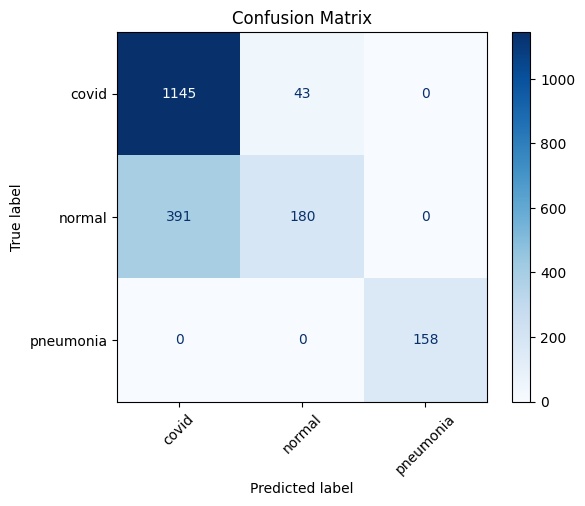

In [45]:

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()